In [ ]:
import os
import sys

module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

from snowflake.snowpark.session import Session

# Snowflake Connection info saved in ../../config/snowflake/SnowflakeSessionProperties.py
from config.snowflake.SnowflakeSessionProperties import SnowflakeSessionProperties
    
# Create Snowpark Session and needed Schema objects.
SnowflakeProps = SnowflakeSessionProperties()
snowflake_connection_properties = SnowflakeProps.get_snowflake_connection_properties()
session = Session.builder.configs(snowflake_connection_properties).create()
session.sql(f"CREATE SCHEMA IF NOT EXISTS {snowflake_connection_properties['schema']};").collect()

# Verify Warehouse, Database and Schema for your current session.
print(session.sql('SELECT current_warehouse(), current_database(), current_schema();').collect())

In [ ]:
# Google Cloud Storage parameters and configurations saved in ../../config/google_cloud/StageProperties.py
from config.google_cloud.StageProperties import StageProperties

StageProperties = StageProperties()
stage_properties = StageProperties.get_gcs_properties()
STORAGE_INTEGRATION_NAME = stage_properties["storage_integration_name"]

BUCKET_NAME = stage_properties["bucket"]
PATH = stage_properties["path_lab3"]
STAGE_NAME = stage_properties["stage_name_lab3"]

# An external stage is a wrapper that references data files stored in a location outside of Snowflake, such as GCS or S3 or Azure Blob Storage ones.
session.sql(f"CREATE STAGE IF NOT EXISTS {STAGE_NAME} \
                url = 'gcs://{BUCKET_NAME}/{PATH}' \
                storage_integration = {STORAGE_INTEGRATION_NAME};"
            ).collect()

# Verify the stage contents and files (returns a set of file paths).
print(session._list_files_in_stage(STAGE_NAME));

In [ ]:
# As you can see from the previous cell result's set, the stage contains 1000 data files in the Parquet format.
# Apache Parquet is a columnar storage format, created to make the advantages of compressed, efficient columnar data representation available to any project in the Hadoop ecosystem.
# It is built to support very efficient compression and encoding schemes, which happens at the column level (similarly to Snowflake Micro-Partitions).

# The goal of this laboratory is to load into two separate DataFrame structures data from Bitcoin and Ethereum candlesticks (high, low, opening and closing prices of a crypto for a specific time window).
# Data files from Bitcoin and Ethereum candlesticks can be identified by the following prefixes:

# - Bitcoin:   .*BTC-EUR.parquet
# - Ethereum:  .*ETH-EUR.parquet

# Hereafter is also provided the schema of each file:

#       #   Column                        Data Type         
#      ---  ------                        ---------      
#       0   open_time                     datetime64[ns]
#       1   open                          float32       
#       2   high                          float32       
#       3   low                           float32       
#       4   close                         float32       
#       5   volume                        float32       
#       6   quote_asset_volume            float32       
#       7   number_of_trades              uint16        
#       8   taker_buy_base_asset_volume   float32       
#       9   taker_buy_quote_asset_volume  float32       

# Read data from Bitcoin and Ethereum candlesticks into two separate DataFrames and load them into Snowflake.

from snowflake.snowpark.types import *

bitcoin_candlesticks_df = session.read.option("pattern", ".*BTC-EUR.parquet").parquet(f"@{STAGE_NAME}")
print(f"Bitcoin Candlesticks: {bitcoin_candlesticks_df.count()}.")

session.sql(f"CREATE FILE FORMAT IF NOT EXISTS LABCAMP_PARQUET_FORMAT TYPE = PARQUET;").collect()
btc_stg_table_name = "STG_BTC_CANDLESTICKS"

# It is possible to create a Snowflake table by inferring the schema from files in stage.
session.sql(f"CREATE TABLE IF NOT EXISTS {btc_stg_table_name} \
            USING TEMPLATE( \
                SELECT ARRAY_AGG(OBJECT_CONSTRUCT(*)) \
                FROM TABLE( \
                    INFER_SCHEMA( \
                        LOCATION => '@{STAGE_NAME}', \
                        FILE_FORMAT => 'LABCAMP_PARQUET_FORMAT' \
                    ) \
                ) \
            );").collect()

bitcoin_candlesticks_df.copy_into_table(btc_stg_table_name)

# Check the load status and the number of discarded rows.
print(session.sql(f"SELECT * FROM information_schema.load_history WHERE schema_name = '{snowflake_connection_properties['schema']}' AND table_name = '{btc_stg_table_name}';").collect())

In [ ]:
from snowflake.snowpark.types import *

ethereum_candlesticks_df = session.read.option("pattern", ".*ETH-EUR.parquet").parquet(f"@{STAGE_NAME}")
print(f"Ethereum Candlesticks: {ethereum_candlesticks_df.count()}.")

eth_stg_table_name = "STG_ETH_CANDLESTICKS"

# It is possible to create a Snowflake table by inferring the schema from files in stage.
session.sql(f"CREATE TABLE IF NOT EXISTS {eth_stg_table_name} \
            USING TEMPLATE( \
                SELECT ARRAY_AGG(OBJECT_CONSTRUCT(*)) \
                FROM TABLE( \
                    INFER_SCHEMA( \
                        LOCATION => '@{STAGE_NAME}', \
                        FILE_FORMAT => 'LABCAMP_PARQUET_FORMAT' \
                    ) \
                ) \
            );").collect()

ethereum_candlesticks_df.copy_into_table(eth_stg_table_name)

# Check the load status and the number of discarded rows.
print(session.sql(f"SELECT * FROM information_schema.load_history WHERE schema_name = '{snowflake_connection_properties['schema']}' AND table_name = '{eth_stg_table_name}';").collect())

In [ ]:
from test_utils.TestResults import TestResults

# Test table counts, column names and types.
tester = TestResults()
tester.test_count(bitcoin_candlesticks_df, 1356570)
tester.test_schema(bitcoin_candlesticks_df, "StructType([StructField('\"open\"', DoubleType(), nullable=True), StructField('\"high\"', DoubleType(), nullable=True), StructField('\"low\"', DoubleType(), nullable=True), StructField('\"close\"', DoubleType(), nullable=True), StructField('\"volume\"', DoubleType(), nullable=True), StructField('\"quote_asset_volume\"', DoubleType(), nullable=True), StructField('\"number_of_trades\"', LongType(), nullable=True), StructField('\"taker_buy_base_asset_volume\"', DoubleType(), nullable=True), StructField('\"taker_buy_quote_asset_volume\"', DoubleType(), nullable=True), StructField('\"open_time\"', LongType(), nullable=True)])")

tester.test_count(ethereum_candlesticks_df, 1356627)
tester.test_schema(ethereum_candlesticks_df, "StructType([StructField('\"open\"', DoubleType(), nullable=True), StructField('\"high\"', DoubleType(), nullable=True), StructField('\"low\"', DoubleType(), nullable=True), StructField('\"close\"', DoubleType(), nullable=True), StructField('\"volume\"', DoubleType(), nullable=True), StructField('\"quote_asset_volume\"', DoubleType(), nullable=True), StructField('\"number_of_trades\"', LongType(), nullable=True), StructField('\"taker_buy_base_asset_volume\"', DoubleType(), nullable=True), StructField('\"taker_buy_quote_asset_volume\"', DoubleType(), nullable=True), StructField('\"open_time\"', LongType(), nullable=True)])")

In [ ]:
# Take a look at the two Snowflake Staging tables for Bitcoin and Ethereum candlesticks.

# Snowflake Staging Table for Bitcoin candlesticks.
stg_btc_candlesticks_df = session.table(btc_stg_table_name)
print(f"{btc_stg_table_name}:")
stg_btc_candlesticks_df.sample(n=10).show()

# Snowflake Staging Table for Ethereum candlesticks.
stg_eth_candlesticks_df = session.table(eth_stg_table_name)
stg_eth_candlesticks_df.sample(n=10).show()

In [7]:
# Now we want to union all the records in the two datasets into a single table.
# An additional column "CRYPTO_CURRENCY" should be included in the final table and the following transformations should be applied over it:

# - CRYPTO_CURRENCY              : "BTC" for Bitcoin candlesticks and "ETH" for Ethereum candlesticks.
# - OPEN_TIME                    : Register a new UDF to be used for converting epoch (microseconds) opening times to timestamps.
# - TAKER_BUY_BASE_ASSET_VOLUME  : Renamed from "taker_buy_base_asset_volume".
# - TAKER_BUY_QUOTE_ASSET_VOLUME : Renamed from "taker_buy_quote_asset_volume".
# - NUMBER_OF_TRADES             : Renamed from "number_of_trades".
# - VOLUME                       : Renamed from "volume".
# - QUOTE_ASSET_VOLUME           : Renamed from "quote_asset_volume".
# - OPEN_PRICE                   : Renamed from "open".
# - CLOSE_PRICE                  : Renamed from "close"
# - LOW_PRICE                    : Renamed from "low".
# - HIGH_PRICE                   : Renamed from "high".

# Work on a sample of N=1000 records before testing with the whole dataset.

from datetime import datetime, timedelta
from snowflake.snowpark.functions import col, lit, udf

@udf(session=session)
def epoch_to_timestamp(
    epoch_microseconds: int
) -> datetime:
    epoch_date = datetime(1970, 1, 1)
    return epoch_date + timedelta(microseconds=epoch_microseconds)

stg_btc_candlesticks_df = stg_btc_candlesticks_df.withColumn("CRYPTO_CURRENCY", lit("BTC")).withColumn("OPENING_TIMESTAMP", epoch_to_timestamp('"open_time"'))
stg_eth_candlesticks_df = stg_eth_candlesticks_df.withColumn("CRYPTO_CURRENCY", lit("ETH")).withColumn("OPENING_TIMESTAMP", epoch_to_timestamp('"open_time"'))

union_df = stg_btc_candlesticks_df.union(stg_eth_candlesticks_df)

norm_crypto_candlesticks = union_df.select(
    col("CRYPTO_CURRENCY"),
    col("OPENING_TIMESTAMP"),
    col('"taker_buy_base_asset_volume"').name("TAKER_BUY_BASE_ASSET_VOLUME"),
    col('"taker_buy_quote_asset_volume"').name("TAKER_BUY_QUOTE_ASSET_VOLUME"),
    col('"number_of_trades"').name("NUMBER_OF_TRADES"),
    col('"volume"').name("VOLUME"),
    col('"quote_asset_volume"').name("QUOTE_ASSET_VOLUME"),
    col('"open"').name("OPEN_PRICE"),
    col('"close"').name("CLOSE_PRICE"),
    col('"low"').name("LOW_PRICE"),
    col('"high"').name("HIGH_PRICE")
)

norm_crypto_candlesticks.write.mode("overwrite").saveAsTable("NORM_CRYPTO_CANDLESTICKS")

In [ ]:
from test_utils.TestResults import TestResults

# Test table counts, column names and types.
tester = TestResults()
tester.test_count(norm_crypto_candlesticks, 2713197)
tester.test_schema(norm_crypto_candlesticks, "StructType([StructField('CRYPTO_CURRENCY', StringType(), nullable=False), StructField('OPENING_TIMESTAMP', TimestampType(), nullable=True), StructField('TAKER_BUY_BASE_ASSET_VOLUME', DoubleType(), nullable=True), StructField('TAKER_BUY_QUOTE_ASSET_VOLUME', DoubleType(), nullable=True), StructField('NUMBER_OF_TRADES', DoubleType(), nullable=True), StructField('VOLUME', DoubleType(), nullable=True), StructField('QUOTE_ASSET_VOLUME', DoubleType(), nullable=True), StructField('OPEN_PRICE', DoubleType(), nullable=True), StructField('CLOSE_PRICE', DoubleType(), nullable=True), StructField('LOW_PRICE', DoubleType(), nullable=True), StructField('HIGH_PRICE', DoubleType(), nullable=True)])")
tester.test_max_value(norm_crypto_candlesticks.filter(col("CRYPTO_CURRENCY") == "BTC"), "OPENING_TIMESTAMP", "2022-08-03 23:02:00")
tester.test_min_value(norm_crypto_candlesticks.filter(col("CRYPTO_CURRENCY") == "BTC"), "OPENING_TIMESTAMP", "2020-01-03 08:00:00")
tester.test_max_value(norm_crypto_candlesticks.filter(col("CRYPTO_CURRENCY") == "ETH"), "OPENING_TIMESTAMP", "2022-08-03 23:59:00")
tester.test_min_value(norm_crypto_candlesticks.filter(col("CRYPTO_CURRENCY") == "ETH"), "OPENING_TIMESTAMP", "2020-01-03 08:00:00")

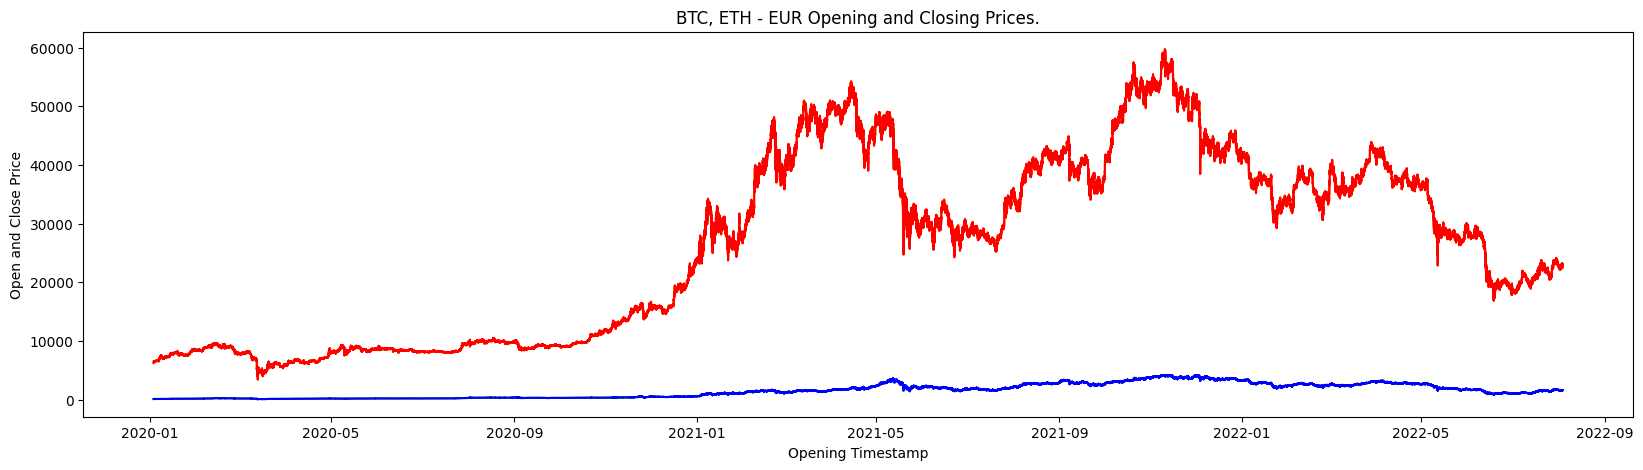

In [9]:
# Using the matplotlib library, plot Opening and Closing prices for BTH and ETH currencies, along the "Opening Timestamp" dimension.

import matplotlib.pyplot as plt
import pandas as pd

norm_crypto_candlesticks_btc = session.sql(
    "SELECT OPENING_TIMESTAMP, \
            OPEN_PRICE, \
            CLOSE_PRICE \
    FROM NORM_CRYPTO_CANDLESTICKS \
    WHERE CRYPTO_CURRENCY = 'BTC'"
).to_pandas().sort_values("OPENING_TIMESTAMP")

norm_crypto_candlesticks_eth = session.sql(
    "SELECT OPENING_TIMESTAMP, \
            OPEN_PRICE, \
            CLOSE_PRICE \
    FROM NORM_CRYPTO_CANDLESTICKS \
    WHERE CRYPTO_CURRENCY = 'ETH'"
).to_pandas().sort_values("OPENING_TIMESTAMP")

plt.figure(figsize=(20, 5))
plt.xlabel("Opening Timestamp")
plt.ylabel('Open and Close Price')
plt.title('BTC, ETH - EUR Opening and Closing Prices.')

plt.plot(
    norm_crypto_candlesticks_btc["OPENING_TIMESTAMP"].values,
    norm_crypto_candlesticks_btc["OPEN_PRICE"].values,
    color="orange",
    label="BTC - Opening Price"
)

plt.plot(
    norm_crypto_candlesticks_eth["OPENING_TIMESTAMP"].values,
    norm_crypto_candlesticks_eth["OPEN_PRICE"].values,
    color="green",
    label="BTC - Opening Price"
)

plt.plot(
    norm_crypto_candlesticks_btc["OPENING_TIMESTAMP"].values,
    norm_crypto_candlesticks_btc["CLOSE_PRICE"].values,
    color="red",
    label="BTC - Closing Price"
)

plt.plot(
    norm_crypto_candlesticks_eth["OPENING_TIMESTAMP"].values,
    norm_crypto_candlesticks_eth["CLOSE_PRICE"].values,
    color="blue",
    label="BTC - Closing Price"
)

plt.show()


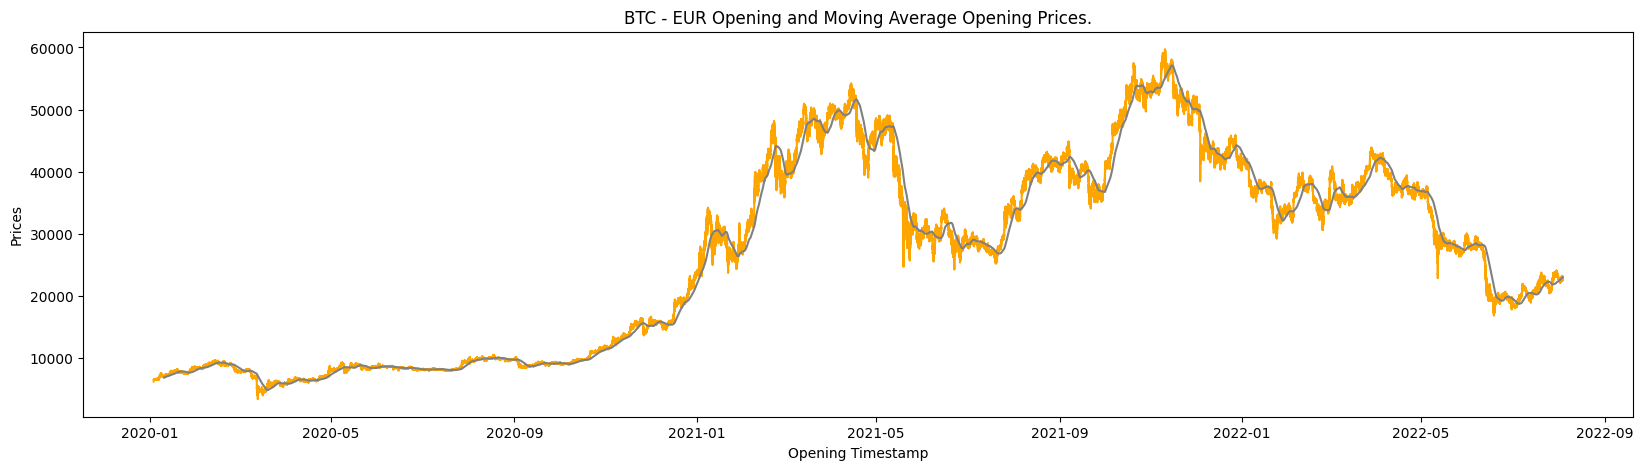

In [30]:
# Find the "MOVING_AVERAGE_OPEN_PRICE" price in a window of 7 days and plot it, together with the standard "OPEN_PRICE".

plt.figure(figsize=(20, 5))
plt.xlabel("Opening Timestamp")
plt.ylabel('Prices')
plt.title('BTC - EUR Opening and Moving Average Opening Prices.')

window = 60 * 24 * 7
norm_crypto_candlesticks_btc["MOVING_AVERAGE_OPEN_PRICE"] = norm_crypto_candlesticks_btc["OPEN_PRICE"].rolling(window).mean()

plt.plot(
    norm_crypto_candlesticks_btc["OPENING_TIMESTAMP"].values,
    norm_crypto_candlesticks_btc["OPEN_PRICE"].values,
    color="orange",
    label="BTC - Opening Price"
)

plt.plot(
    norm_crypto_candlesticks_btc["OPENING_TIMESTAMP"].values,
    norm_crypto_candlesticks_btc["MOVING_AVERAGE_OPEN_PRICE"].values,
    color="grey",
    label="BTC - Moving Average Opening Price"
)

plt.show()

In [ ]:
# The "VOLUME" attribute denotes the number of units of a given Crypto Currency traded in a market during a given time.
# The "TAKER_BUY_BASE_ASSET_VOLUME" instead represents how many units of the total base asset volume are contributed by the Taker's buy order.
# The "QUOTE_ASSET_VOLUME" represents the sum of (price * volume) for all the trades in a given period.

# Find the top 50 opening timestamps for "BTC", having the highest weighted average price ("QUOTE_ASSET_VOLUME"/"VOLUME").

from snowflake.snowpark.functions import coalesce

top_50_weighted_average_price_df = session.table("NORM_CRYPTO_CANDLESTICKS") \
.filter((col("CRYPTO_CURRENCY") == "BTC") & (col("VOLUME") != "0")) \
.withColumn("WEIGHTED_AVG_PRICE", col("QUOTE_ASSET_VOLUME") / (col("VOLUME"))) \
.sort(col("WEIGHTED_AVG_PRICE").desc()) \
.limit(50)

top_50_weighted_average_price_df.show()